# AWS Access

A growing number of CORDEX datasets is now available from AWS S3. In this examples, we will show how to access the datasets using an ESM collection and derive an ensemble mean.

In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41235,Workers: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:41111,Total threads: 16
Dashboard: /user/g300046/levante-spawner-preset//proxy/40821/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:41607,


In [2]:
import cf_xarray as cfxr
import fsspec
import intake
import xarray as xr

url = "https://euro-cordex.s3.eu-central-1.amazonaws.com/catalog/CORDEX-CMIP5.json"
cat = intake.open_esm_datastore(url)

In [3]:
cat

,unique
project_id,1
product,1
CORDEX_domain,1
institute_id,12
driving_model_id,10
experiment_id,5
member,4
model_id,13
rcm_version_id,4
frequency,1


In [4]:
cat.df.head()

,project_id,product,CORDEX_domain,institute_id,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,variable_id,version,path
0,cordex,output,EUR-11,CLMcom-ETH,MPI-M-MPI-ESM-LR,historical,r1i1p1,COSMO-crCLIM-v1-1,v1,mon,tas,v20191219,s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
1,cordex,output,EUR-11,SMHI,CNRM-CERFACS-CNRM-CM5,historical,r1i1p1,RCA4,v1,mon,tas,v20131026,s3://euro-cordex/CMIP5/cordex/output/EUR-11/SM...
2,cordex,output,EUR-11,CLMcom-ETH,CNRM-CERFACS-CNRM-CM5,rcp85,r1i1p1,COSMO-crCLIM-v1-1,v1,mon,tas,v20210430,s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
3,cordex,output,EUR-11,KNMI,ICHEC-EC-EARTH,historical,r3i1p1,RACMO22E,v1,mon,tas,v20190108,s3://euro-cordex/CMIP5/cordex/output/EUR-11/KN...
4,cordex,output,EUR-11,DMI,CNRM-CERFACS-CNRM-CM5,rcp85,r1i1p1,HIRHAM5,v2,mon,tas,v20190208,s3://euro-cordex/CMIP5/cordex/output/EUR-11/DM...


We can open a single datasets from S3 by using the URL from data dataframe, e.g., to look at

In [5]:
cat.df.iloc[0]

project_id                                                     cordex
product                                                        output
CORDEX_domain                                                  EUR-11
institute_id                                               CLMcom-ETH
driving_model_id                                     MPI-M-MPI-ESM-LR
experiment_id                                              historical
member                                                         r1i1p1
model_id                                            COSMO-crCLIM-v1-1
rcm_version_id                                                     v1
frequency                                                         mon
variable_id                                                       tas
version                                                     v20191219
path                s3://euro-cordex/CMIP5/cordex/output/EUR-11/CL...
Name: 0, dtype: object

we can open this dataset using xarray with zarr

In [6]:
ds = xr.open_zarr(
    store=fsspec.get_mapper(cat.df.iloc[0].path, anon=True), consolidated=True
)
ds

<xarray.Dataset>
Dimensions:       (rlat: 412, rlon: 424, time: 684, bnds: 2)
Coordinates:
    height        float64 ...
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat          (rlat) float64 -23.38 -23.26 -23.16 ... 21.61 21.73 21.83
  * rlon          (rlon) float64 -28.38 -28.26 -28.16 ... 17.93 18.05 18.16
  * time          (time) datetime64[ns] 1949-01-16T12:00:00 ... 2005-12-16T12...
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  |S1 ...
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(143, 412, 424), meta=np.ndarray>
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(143, 2), meta=np.ndarray>
Attributes: (12/26)
    CORDEX_domain:                  EUR-11
    Conventions:                    CF-1.4
    c3s_disclaimer:                 This data has been produced in the contex...
    comment:                        Please use the following reference for th...
    config_cclm:                    EUR-11_CLMcom-ETH-COSMO-crCLIM-v1-1_01_co...
    config_int2lm:                  EUR-11_int2lm2.5.1_01_config
    ...                             ...
    project_id:                     CORDEX
    rcm_version_id:                 v1
    references:                     http://cordex.clm-community.eu/
    source:                         Climate Limited-area Modelling Community ...
    title:                          CLMcom-ETH-COSMO-crCLIM-v1-1 model output...
    tracking_id:                    151e60a4-e4c0-11e9-a214-d09466354597

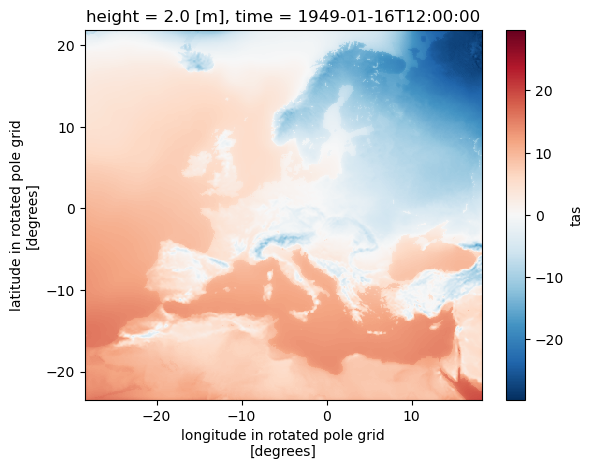

In [7]:
(ds.tas.isel(time=0) - 273.5).plot()

In [8]:
ds.close()

## Open an ESM collection

We can also use intake to open a collection of datasets into a dictionary. E.g., to open up all 2m temperature datasets, we search for them in the catalog:

In [9]:
subset = cat.search(
    variable_id="tas", experiment_id=["historical", "rcp26", "rcp45", "rcp85"]
)
subset

,unique
project_id,1
product,1
CORDEX_domain,1
institute_id,11
driving_model_id,9
experiment_id,4
member,4
model_id,12
rcm_version_id,4
frequency,1


In [11]:
dsets = subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    storage_options={"anon": True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.CORDEX_domain.institute_id.driving_model_id.experiment_id.member.model_id.rcm_version_id.frequency'


Let's check the size of all datasets we just opened lazily!

In [12]:
size = sum([ds.nbytes for ds in dsets.values()])
print(f"Total size: {size/1.e9} GB")

Total size: 117.931165865 GB


There are different numbers of datsets for each scenario. For later computations, it's useful to sort those datasets out. We will also combine scenario data with historical data so we can make a running mean easily.

In [13]:
from collections import defaultdict, OrderedDict

import tqdm


def sort_datasets(dsets):
    """sort datasets by scenario and append historical data"""
    results = defaultdict(dict)
    for dset_id, ds in tqdm.tqdm(dsets.items()):
        exp_id = dset_id.split(".")[4]
        new_id = dset_id.replace(f"{exp_id}.", "")
        # collect historical
        if exp_id == "historical":
            results[exp_id][new_id] = ds
            continue
        # if scenario, look for corresponding historical data
        # and concat if historical is available
        hist_id = dset_id.replace(exp_id, "historical")
        if hist_id not in dsets.keys():
            print(f"historical not found: {hist_id}")
            continue
            # results[exp_id][new_id] = v
        else:
            results[exp_id][new_id] = xr.concat(
                [dsets[hist_id][["tas"]], ds[["tas"]]], dim="time"
            )
    return results


def sort_datasets(dsets):
    results = defaultdict(dict)
    for dset_id, ds in tqdm.tqdm(dsets.items()):
        exp_id = dset_id.split(".")[4]
        new_id = dset_id.replace(f"{exp_id}.", "")
        if exp_id != "historical":
            ds = ds.sel(time=slice("2006", "2100"))
        else:
            ds = ds.sel(time=slice("1950", "2005"))
        results[exp_id][new_id] = ds
    return OrderedDict(sorted(results.items()))


dsets_sorted = sort_datasets(dsets)

100%|██████████| 165/165 [00:00<00:00, 464.92it/s]


In [14]:
dsets_sorted["historical"][
    "cordex.EUR-11.CLMcom.ICHEC-EC-EARTH.r12i1p1.CCLM4-8-17.v1.mon"
]

<xarray.Dataset>
Dimensions:                     (rlat: 412, rlon: 424, vertices: 4, time: 672,
                                 bnds: 2)
Coordinates:
    height                      float64 ...
    lat                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
  * time                        (time) object 1950-01-16 12:00:00 ... 2005-12...
Dimensions without coordinates: vertices, bnds
Data variables:
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    rotated_latitude_longitude  int32 ...
    tas                         (time, rlat, rlon) float32 dask.array<chunksize=(142, 412, 424), meta=np.ndarray>
    time_bnds                   (time, bnds) object dask.array<chunksize=(142, 2), meta=np.ndarray>
Attributes: (12/45)
    CORDEX_domain:                      EUR-11
    Conventions:                        CF-1.4
    cmor_version:                       2.9.1
    comment:                            CORDEX Europe RCM CCLM 0.11 deg EUR-11
    contact:                            cordex-cclm@dkrz.de
    creation_date:                      2014-03-19T07:56:10Z
    ...                                 ...
    intake_esm_attrs:frequency:         mon
    intake_esm_attrs:variable_id:       tas
    intake_esm_attrs:version:           v20140515
    intake_esm_attrs:path:              s3://euro-cordex/CMIP5/cordex/output/...
    intake_esm_attrs:_data_format_:     zarr
    intake_esm_dataset_key:             cordex.EUR-11.CLMcom.ICHEC-EC-EARTH.h...

Let's check out a yearly rolling mean of a single dataset:

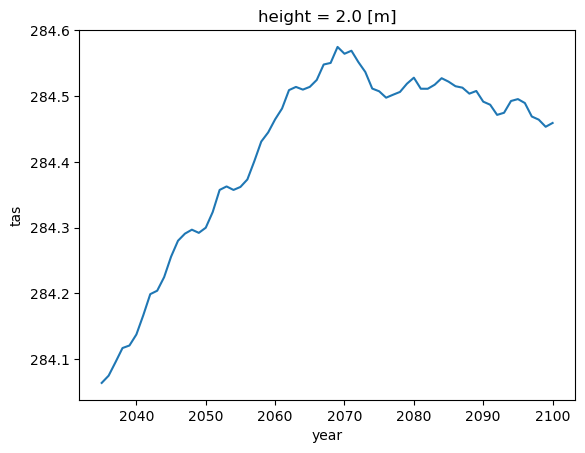

In [15]:
dsets_sorted["rcp26"][
    "cordex.EUR-11.CLMcom.ICHEC-EC-EARTH.r12i1p1.CCLM4-8-17.v1.mon"
].tas.groupby("time.year").mean().cf.mean(("X", "Y")).rolling(year=30).mean().plot()

## Investigate regional warming in the entire ensemble

Let's do it for the whole ensemble! We define a function to compute a simple yearly mean and a function that concatenates all yearly datasets into one ensemble dataset.

In [16]:
xr.set_options(keep_attrs=True)


def yearly_mean(ds):
    """compute yearly mean for one dataset"""
    return ds.groupby("time.year").mean().cf.mean(("X", "Y"))


def ensemble_mean(dsets):
    """compute ensemble yearly mean"""
    return xr.concat(
        [yearly_mean(ds.tas) for ds in dsets.values()],
        dim=xr.DataArray(list(dsets.keys()), dims="dset_id"),
        coords="minimal",
        compat="override",
    )

Now, we can create a dictionary of ensemble means for each scenario. Here we 'hit the compute button' to store those results in memory. This can take some minutes since we reduce the spatical and temporal dimensions of the whole ensemble:

In [17]:
%time ensembles = {exp_id: ensemble_mean(dsets).compute() for exp_id, dsets in dsets_sorted.items()}

CPU times: user 1min 14s, sys: 4.83 s, total: 1min 19s
Wall time: 2min 15s


In [21]:
ensembles.keys()

dict_keys(['historical', 'rcp26', 'rcp45', 'rcp85'])

In the following step, we concatenate all scenario ensembles into one dataset with the scneario as a coordinate. That will make analysis and plotting much easier.

In [22]:
ensemble = xr.concat(
    [ds.copy(deep=True) for ds in ensembles.values()],
    dim=xr.DataArray(list(ensembles.keys()), dims="experiment_id"),
)

Let's check again the size of our reduced dataset.

In [23]:
print(f"Total size: {ensemble.nbytes/1.e6} MB")

Total size: 0.152208 MB


This is for some datasets that actually have temperature data in degrees Celsius:

In [24]:
dset_id = ensemble.where(ensemble < 100.0, drop=True).dset_id
ensemble.loc[dict(dset_id=dset_id)] = ensemble.sel(dset_id=dset_id) + 273.5

Let's check the data we got by plotting an overview for each scenario.

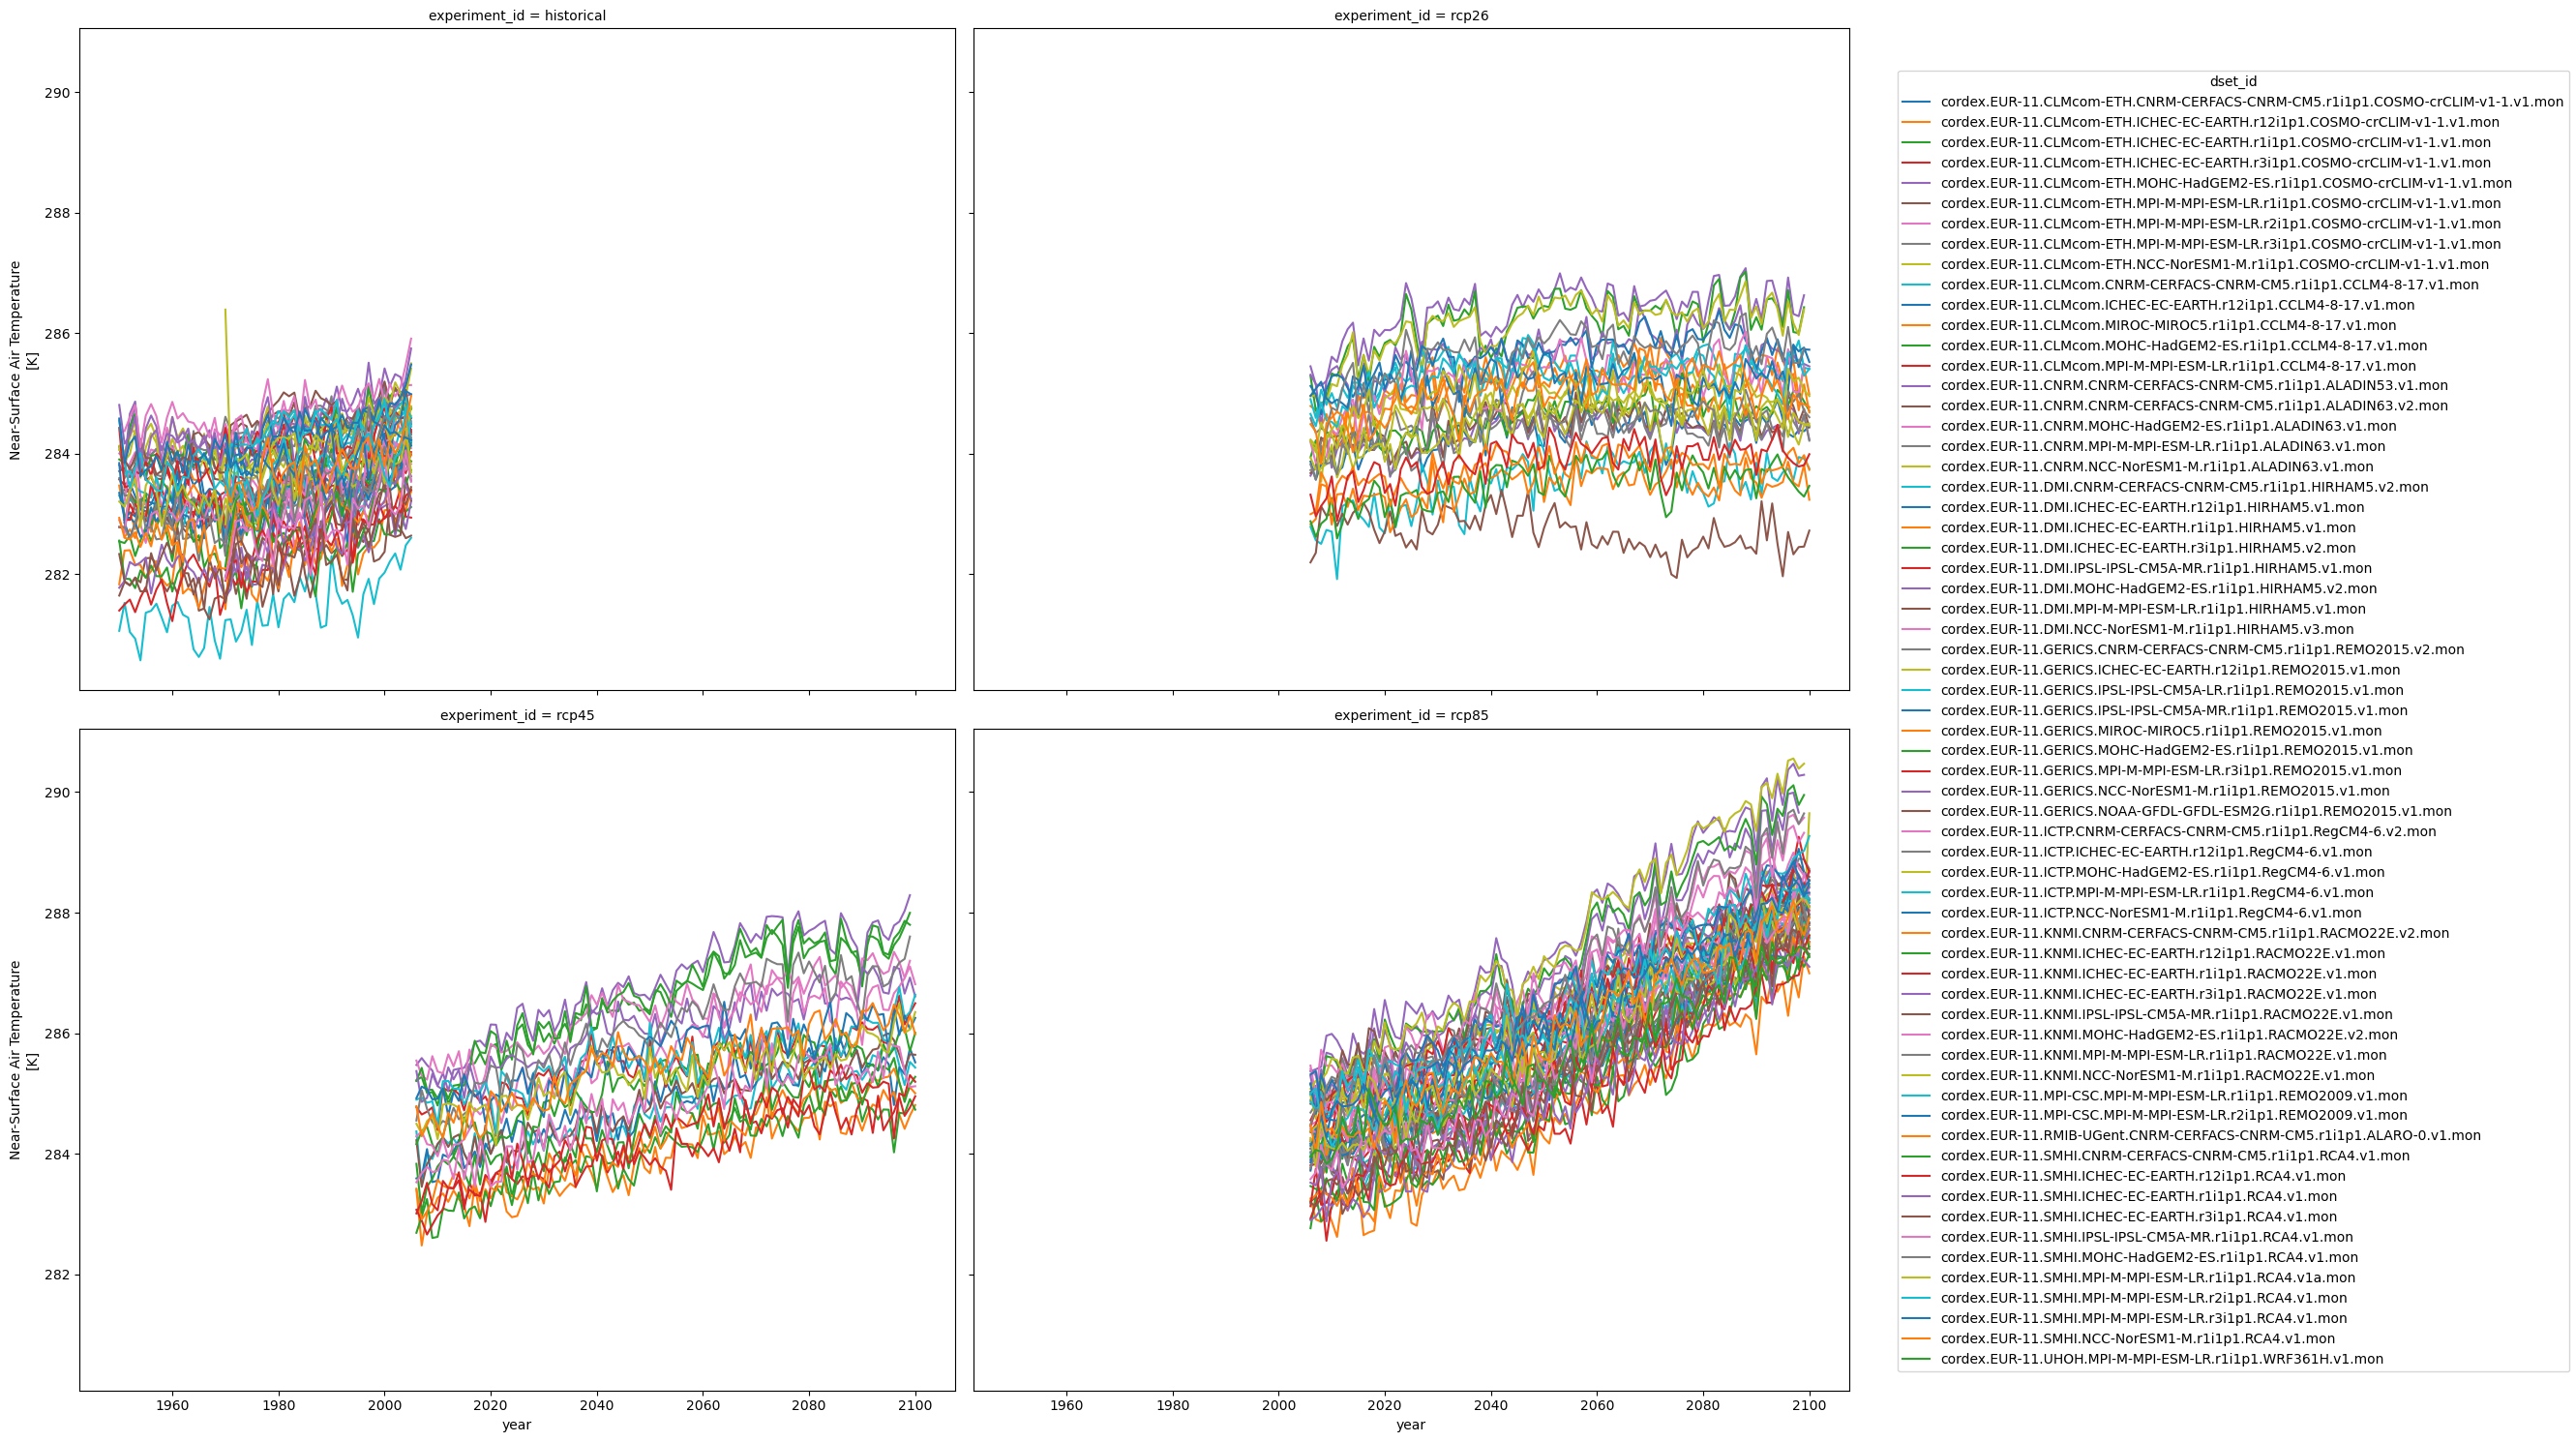

In [25]:
ensemble.plot(col="experiment_id", col_wrap=2, hue="dset_id", figsize=(20, 15))

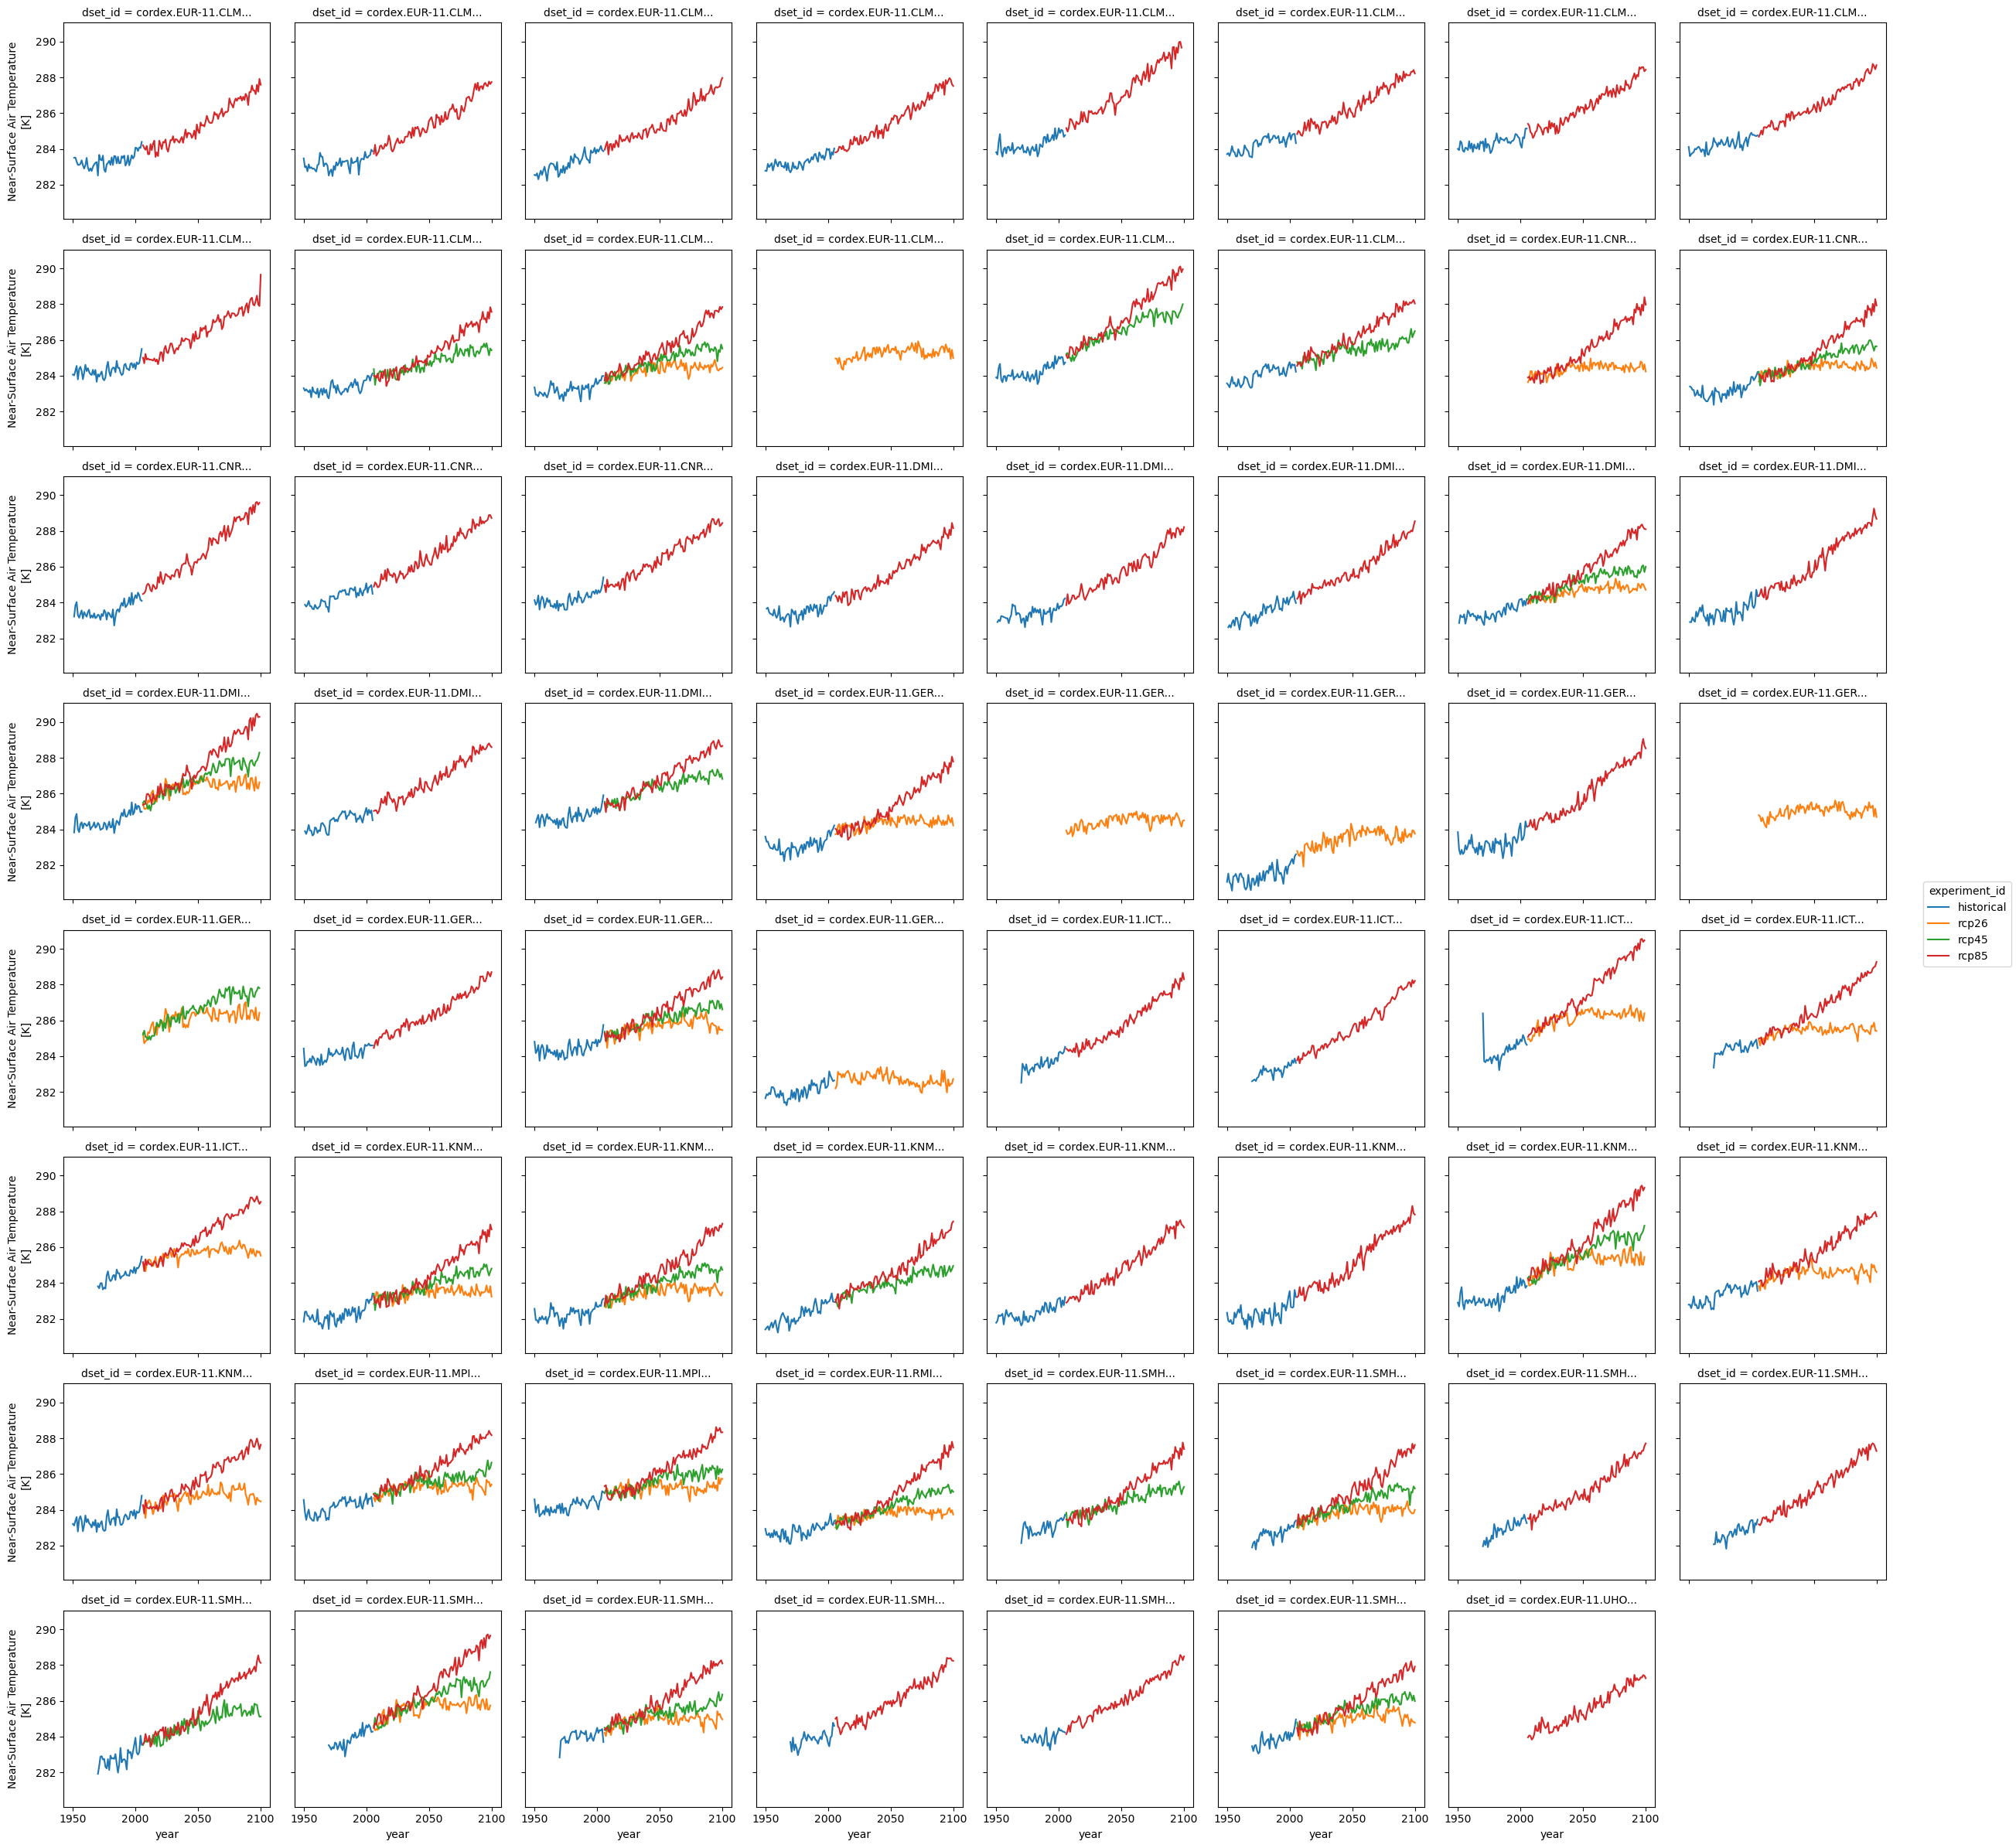

In [26]:
ensemble.plot(hue="experiment_id", col="dset_id", col_wrap=8)

### Use seaborn for statistical plots

These plots are nice but don't really give some valuable statistical insight. However, we can easily convert our dataset to a pandas dataframe and use, e.g., seaborn for stastical plots:

In [27]:
df = ensemble.to_dataframe().reset_index()
df

,experiment_id,dset_id,year,height,tas
0,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1950,2.0,NaN
1,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1951,2.0,283.503998
2,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1952,2.0,283.518219
3,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1953,2.0,283.295319
4,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1954,2.0,283.110107
...,...,...,...,...,...
38047,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2096,2.0,287.308136
38048,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2097,2.0,287.299774
38049,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2098,2.0,287.437317
38050,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2099,2.0,287.403107


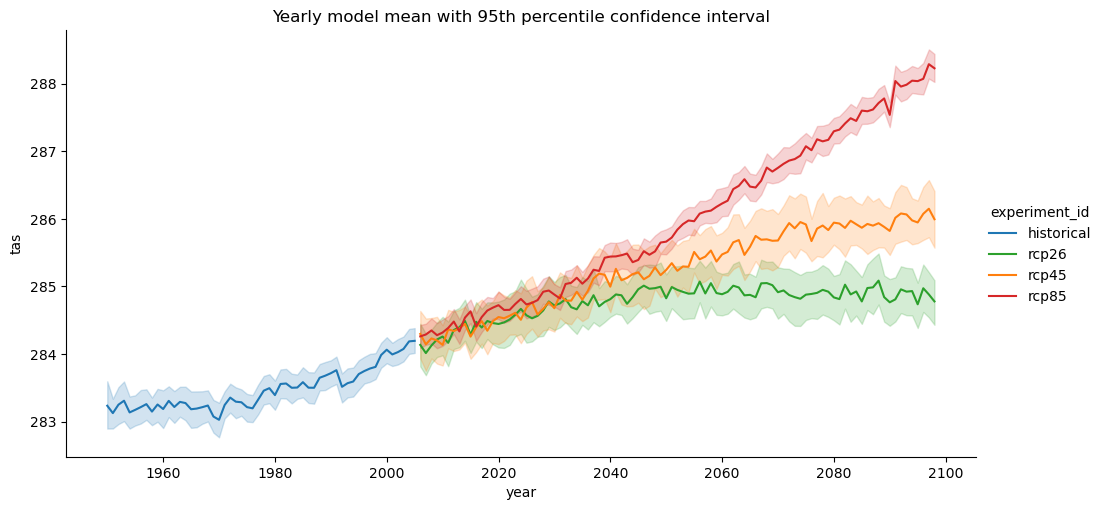

In [28]:
import seaborn as sns

palette = {"historical": "C0", "rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(
    data=df[(df["year"] >= 1950) & (df["year"] <= 2098)],
    x="year",
    y="tas",
    hue="experiment_id",
    kind="line",
    errorbar=("ci", 95),
    aspect=2,
    palette=palette,
)
g.set(title="Yearly model mean with 95th percentile confidence interval")

## Compute the change in the rolling yearly mean

Ususally, it's easier to look at at rolling mean with a window size of a climate timescale, e.g., a decade. We can achieve this but we have to take care to fill the scenario datasets with historical data so that we don't get a 'gap' in the data when computing the rolling mean. We can achive this by using xarrays index notation similar to pandas:

In [29]:
def rolling_mean(ensemble, n):
    """compute a rolling mean

    Take care to fill scenario timelines with historical data.

    """
    year = slice(2005 - n + 1, 2005)
    ensemble.loc[
        dict(experiment_id=["rcp26", "rcp45", "rcp85"], year=year)
    ] = ensemble.sel(experiment_id="historical").sel(year=year)

    return ensemble.rolling(year=n, center=False).mean()

In [30]:
mean = rolling_mean(ensemble, 10)

Instead of looking at absolute values, it's more interesting to look at the change in temperature with respect to a reference period. Here we choose a reference period from 1961-1990 from the historical runs.

In [31]:
mean = mean - mean.sel(experiment_id="historical", year=slice(1961, 1990)).mean("year")
mean

<xarray.DataArray 'tas' (experiment_id: 4, dset_id: 63, year: 151)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ..., 2.580017 , 2.627594 ,
         2.588501 ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 3.993927 , 4.091522 ,
         4.2050476],
        [      nan,       nan,       nan, ..., 4.4456177, 4.4381714,
         4.487091 ],
        [      nan,       nan,       nan, ..., 4.3269653, 4.3974915,
         4.467041 ],
        ...,
        [      nan,       nan,       nan, ..., 4.248413 , 4.331543 ,
         4.4112244],
        [      nan,       nan,       nan, ..., 4.158966 , 4.149475 ,
         4.22229  ],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * year           (year) int64 1950 1951 1952 1953 1954 ... 2097 2098 2099 2100
  * dset_id        (dset_id) <U78 'cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM...
    height         float64 2.0
  * experiment_id  (experiment_id) <U10 'historical' 'rcp26' 'rcp45' 'rcp85'
Attributes:
    cell_methods:        time: mean
    grid_mapping:        Lambert_Conformal
    interval_operation:  450 s
    interval_write:      1 month
    long_name:           Near-Surface Air Temperature
    online_operation:    average
    standard_name:       air_temperature
    units:               K

Again we will convert the data to a dataframe and use seaborn for a statistical plot.

In [32]:
df = mean.to_dataframe().reset_index()
df

,experiment_id,dset_id,year,height,tas
0,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1950,2.0,NaN
1,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1951,2.0,NaN
2,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1952,2.0,NaN
3,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1953,2.0,NaN
4,historical,cordex.EUR-11.CLMcom-ETH.CNRM-CERFACS-CNRM-CM5...,1954,2.0,NaN
...,...,...,...,...,...
38047,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2096,2.0,NaN
38048,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2097,2.0,NaN
38049,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2098,2.0,NaN
38050,rcp85,cordex.EUR-11.UHOH.MPI-M-MPI-ESM-LR.r1i1p1.WRF...,2099,2.0,NaN


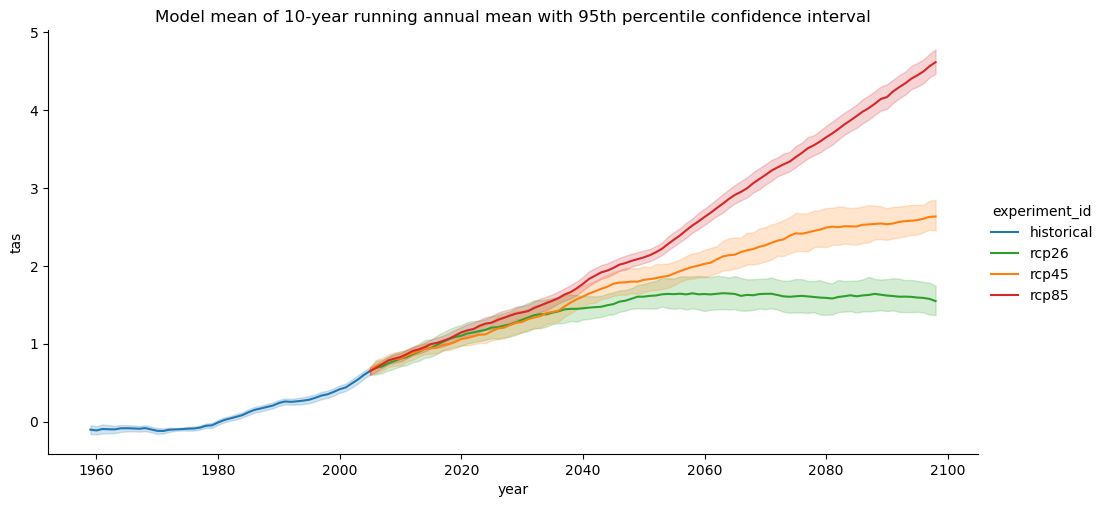

In [33]:
import seaborn as sns

palette = {"historical": "C0", "rcp26": "C2", "rcp45": "C1", "rcp85": "C3"}
g = sns.relplot(
    data=df[(df["year"] >= 1950) & (df["year"] <= 2098)],
    x="year",
    y="tas",
    hue="experiment_id",
    kind="line",
    errorbar=("ci", 95),
    aspect=2,
    palette=palette,
)
g.set(
    title="Model mean of 10-year running annual mean with 95th percentile confidence interval"
)